### GRASS analysis for Windows 10 version

In [27]:
#from rasterio.warp import calculate_default_transform,reproject,Resampling
#from shapely import BufferCapStyle, BufferJoinStyle, buffer
#from shapely.geometry import shape, Point, Polygon
#from shapely.ops import transform
#from osgeo import gdal
#import matplotlib.pyplot as plt
#import rasterio as rio
#import rasterio.mask
#import ipywidgets as widgets
import geopandas as gpd
import pandas as pd
import altair as alt
import numpy as np
import ipyleaflet
#import matplotlib
import subprocess
#import requests
import shapely
import plotly
import pyproj
import folium
import branca
#import glob
import pdal
import math
import json
import copy
import sys
import os
import io

In [24]:
print(f"GDAL version: {gdal.__version__}")
print(f"python version:{sys.version[:6]}")

GDAL version: 3.8.3
python version:3.10.1


In [3]:
# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["C:\Program Files\GRASS GIS 8.3\grass83.bat", "--config", "python_path"], text=True).strip()
)

In [4]:
# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

import shutil
from pathlib import Path

In [6]:
os.chdir(r"C:\Users\jvonnonn\research_proj\incised_meadows\meadow_temp")

In [7]:
#checking if "temp_location" exists, then deleting
dirpath = Path('temp_location')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

In [8]:
!grass83 -c C:/Users/jvonnonn/research_proj/incised_meadows/meadow_temp/dtm_temp.tif -e C:/Users/jvonnonn/research_proj/incised_meadows/meadow_temp/temp_location

Error in sitecustomize; set PYTHONVERBOSE for traceback:
OSError: [WinError 87] The parameter is incorrect: '.'
Creating new GRASS GIS location <temp_location>...


In [9]:
session = gj.init(r"C:/Users/jvonnonn/research_proj/incised_meadows/meadow_temp/temp_location")

In [10]:
gs.run_command("r.external", input="dtm_clipped.tif", out="dtm")

gs.run_command("r.stream.extract", elevation="dtm", threshold=500,
                mexp=0.5, stream_length=500, memory=100000, stream_raster="stream_r",
                direction="direction_r", stream_vector="stream_vect")

gs.run_command("r.accumulate", direction="direction_r",format="auto",accumulation_type="CELL",accumulation="accum",
               outlet="stream_vect", longest_flow_path="longest_stream")

gs.run_command("r.stream.order", stream_rast="stream_r", accumulation="accum", direction="direction_r",
                elevation="dtm",hack="stream_hack", stream_vect="stream_v")

!r.mapcalc "main_channel = if(stream_hack != 1, null(), 1)"

gs.run_command("r.to.vect", input="main_channel", output="mc_vect", type="line")

In [12]:
!v.build.polylines input=mc_vect output=polylines 

!v.out.ogr input=polylines type=line output=poly_test.geojson format=GeoJSON -c

p = gpd.read_file('poly_test.geojson')

p_longest = p[p.length == p.length.max()]

p_longest.to_file('p_longest.geojson',driver="GeoJSON")

!v.in.ogr input=p_longest.geojson output=plong

!v.generalize input=plong type=line method=snakes threshold=1 output=plong_simp

gs.run_command("v.transects", input="plong_simp", output="transects",
                transect_spacing=10, transect_perpendicular="trend")

Building topology for vector map <polylines@PERMANENT>...
Registering primitives...

         attributes
Exporting 28 features...
   7  14  21  28  35  42  50  57  64  71  78  85  92 100
28 features without category were written
v.out.ogr complete. 28 features (Line String type) written to <polylines>
(GeoJSON format).
Check if OGR layer <p_longest> contains polygons...
   0 100
Creating attribute table for layer <p_longest>...
Importing 1 features (OGR layer <p_longest>)...
   0 100
-----------------------------------------------------
Building topology for vector map <plong@PERMANENT>...
Registering primitives...

Copying features...
 100
Building topology for vector map <plong_simp@PERMANENT>...
Registering primitives...

-----------------------------------------------------
Generalization (snakes)...
Using threshold: 1 meters
 100
-----------------------------------------------------
Building topology for vector map <plong_simp@PERMANENT>...
Registering primitives...

-------------

In [13]:
gs.run_command("v.to.points", input="transects", out="points", use="vertex")

result = gs.read_command("v.out.ascii", input="points", separator=",")

df = pd.DataFrame([row.rsplit(',',1) for row in result.splitlines()],
                  columns=["coors","cat"])

df = df.groupby('cat')['coors'].apply(','.join).reset_index()

profiles = {}

for index, row in df.iterrows():
    profile = gs.read_command("r.profile", input="dtm",
                              coordinates=(row["coors"]))
    profile_df = pd.DataFrame([row.split() for row in profile.splitlines()],
                              columns=["distance", "elevation"])
    profiles[row["cat"]] = profile_df.apply(pd.to_numeric, errors='coerce')

In [30]:
!v.out.ogr input=transects type=line output=transects.geojson format=GeoJSON -c

         attributes
Exporting 344 features...
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
v.out.ogr complete. 344 features (Line String type) written to <transects>
(GeoJSON format).


In [16]:
shapefile_path = 'meadow_extent.geojson'

In [17]:
#alternative way to read in geojson for rasterio mask
gdf = gpd.read_file(shapefile_path)
gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
center = gdf['geometry'].centroid
center = center.to_crs(4326)
loc = shapely.get_coordinates(center)

In [28]:
html = []
for keys in profiles:
    df = pd.DataFrame({'distance_(m)':profiles[keys]['distance'],'elevation_(m)':profiles[keys]['elevation']})
    line = alt.Chart(df).mark_line().encode(
        alt.X('distance_(m)'),
        alt.Y('elevation_(m):Q',scale=alt.Scale(zero=False))
    ).properties(width=600,height=60)
    test = line.to_dict()
    #vega_lite = folium.VegaLite(line, width='100%',height='100%')
    html.append(test)

In [31]:
plngest = gpd.read_file('plong_simp.geojson').to_crs(4326)
trnscts = gpd.read_file('transects.geojson').to_crs(4326)

In [32]:
trnscts['html'] = html

In [36]:
gs.run_command("r.geomorphon", forms="forms", elevation="dtm", search=10, skip=3, flat=2.5)

### Visualization

In [38]:
aoi = gdf
m = folium.Map(location=[loc[0][1],loc[0][0]], zoom_start=14, max_zoom=18)

#folium.TileLayer("USGS.USImageryTopo").add_to(m)

gj.Raster('dtm').add_to(m) #need to set nul to display correctly
gj.Raster('forms').add_to(m)
#gj.Raster('hand').add_to(m) #add HAND

folium.GeoJson(
    plngest,
    name='main channel',
    style_function=lambda x:{'color':'red'}
    #tooltip = folium.GeoJsonTooltip(['LOCATION '], labels=False),
).add_to(m)

folium.GeoJson(
    aoi,
    name='AOI'
).add_to(m)

fg =folium.FeatureGroup(name='Transects').add_to(m)
for _, s in trnscts.iterrows():

    graph = s['html']
    coords = list(s['geometry'].coords)
    ttip = s['cat']

    geo_data={"type":"Polygon","coordinates":[coords]}
    geo_obj=folium.GeoJson(geo_data, style_function=lambda x:{'color':'gray','weight':4,'dashArray':"2,2"},
                            highlight_function=lambda x:{'color':'yellow','weight':8},
                            tooltip=folium.Tooltip(ttip),
                            popup=folium.Popup().add_child(folium.VegaLite(graph,width="100%")),
                            #popup_keep_highlighted=True, #needs python 3.9?
                            )
    #geo_obj.add_child(folium.Popup(max_width=500).add_child(folium.VegaLite(graph)))
    geo_obj.add_to(fg)


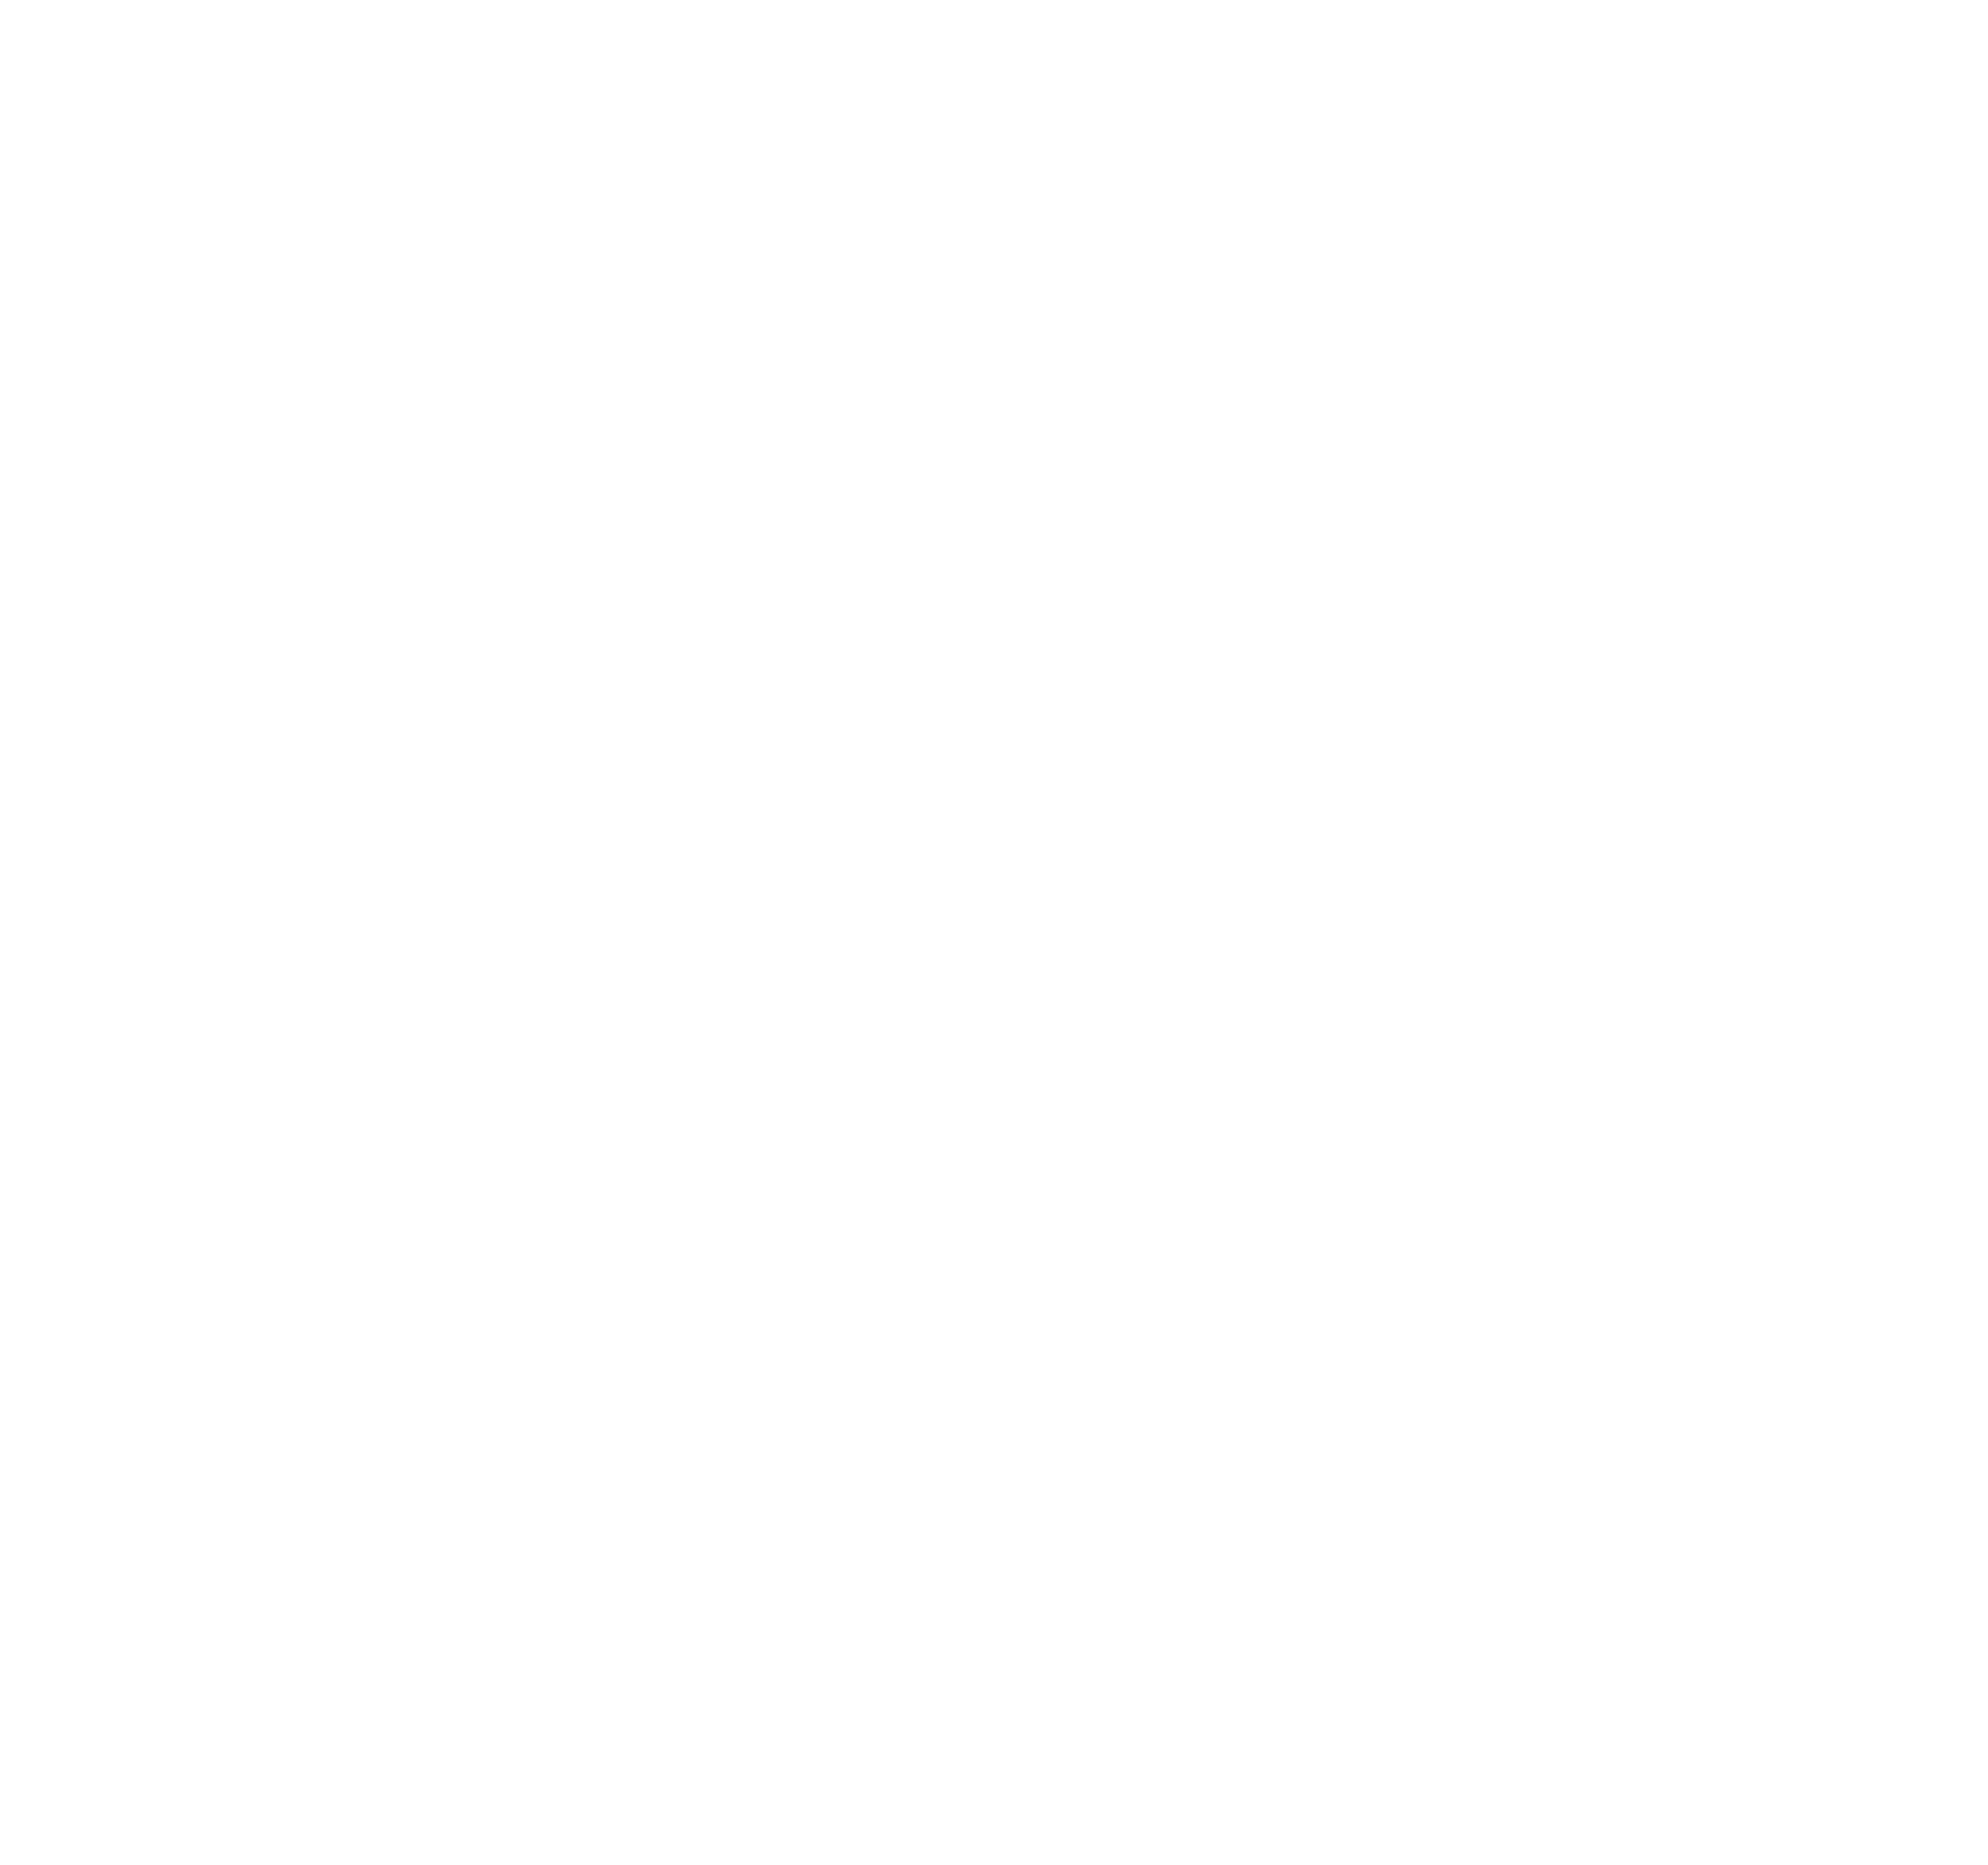
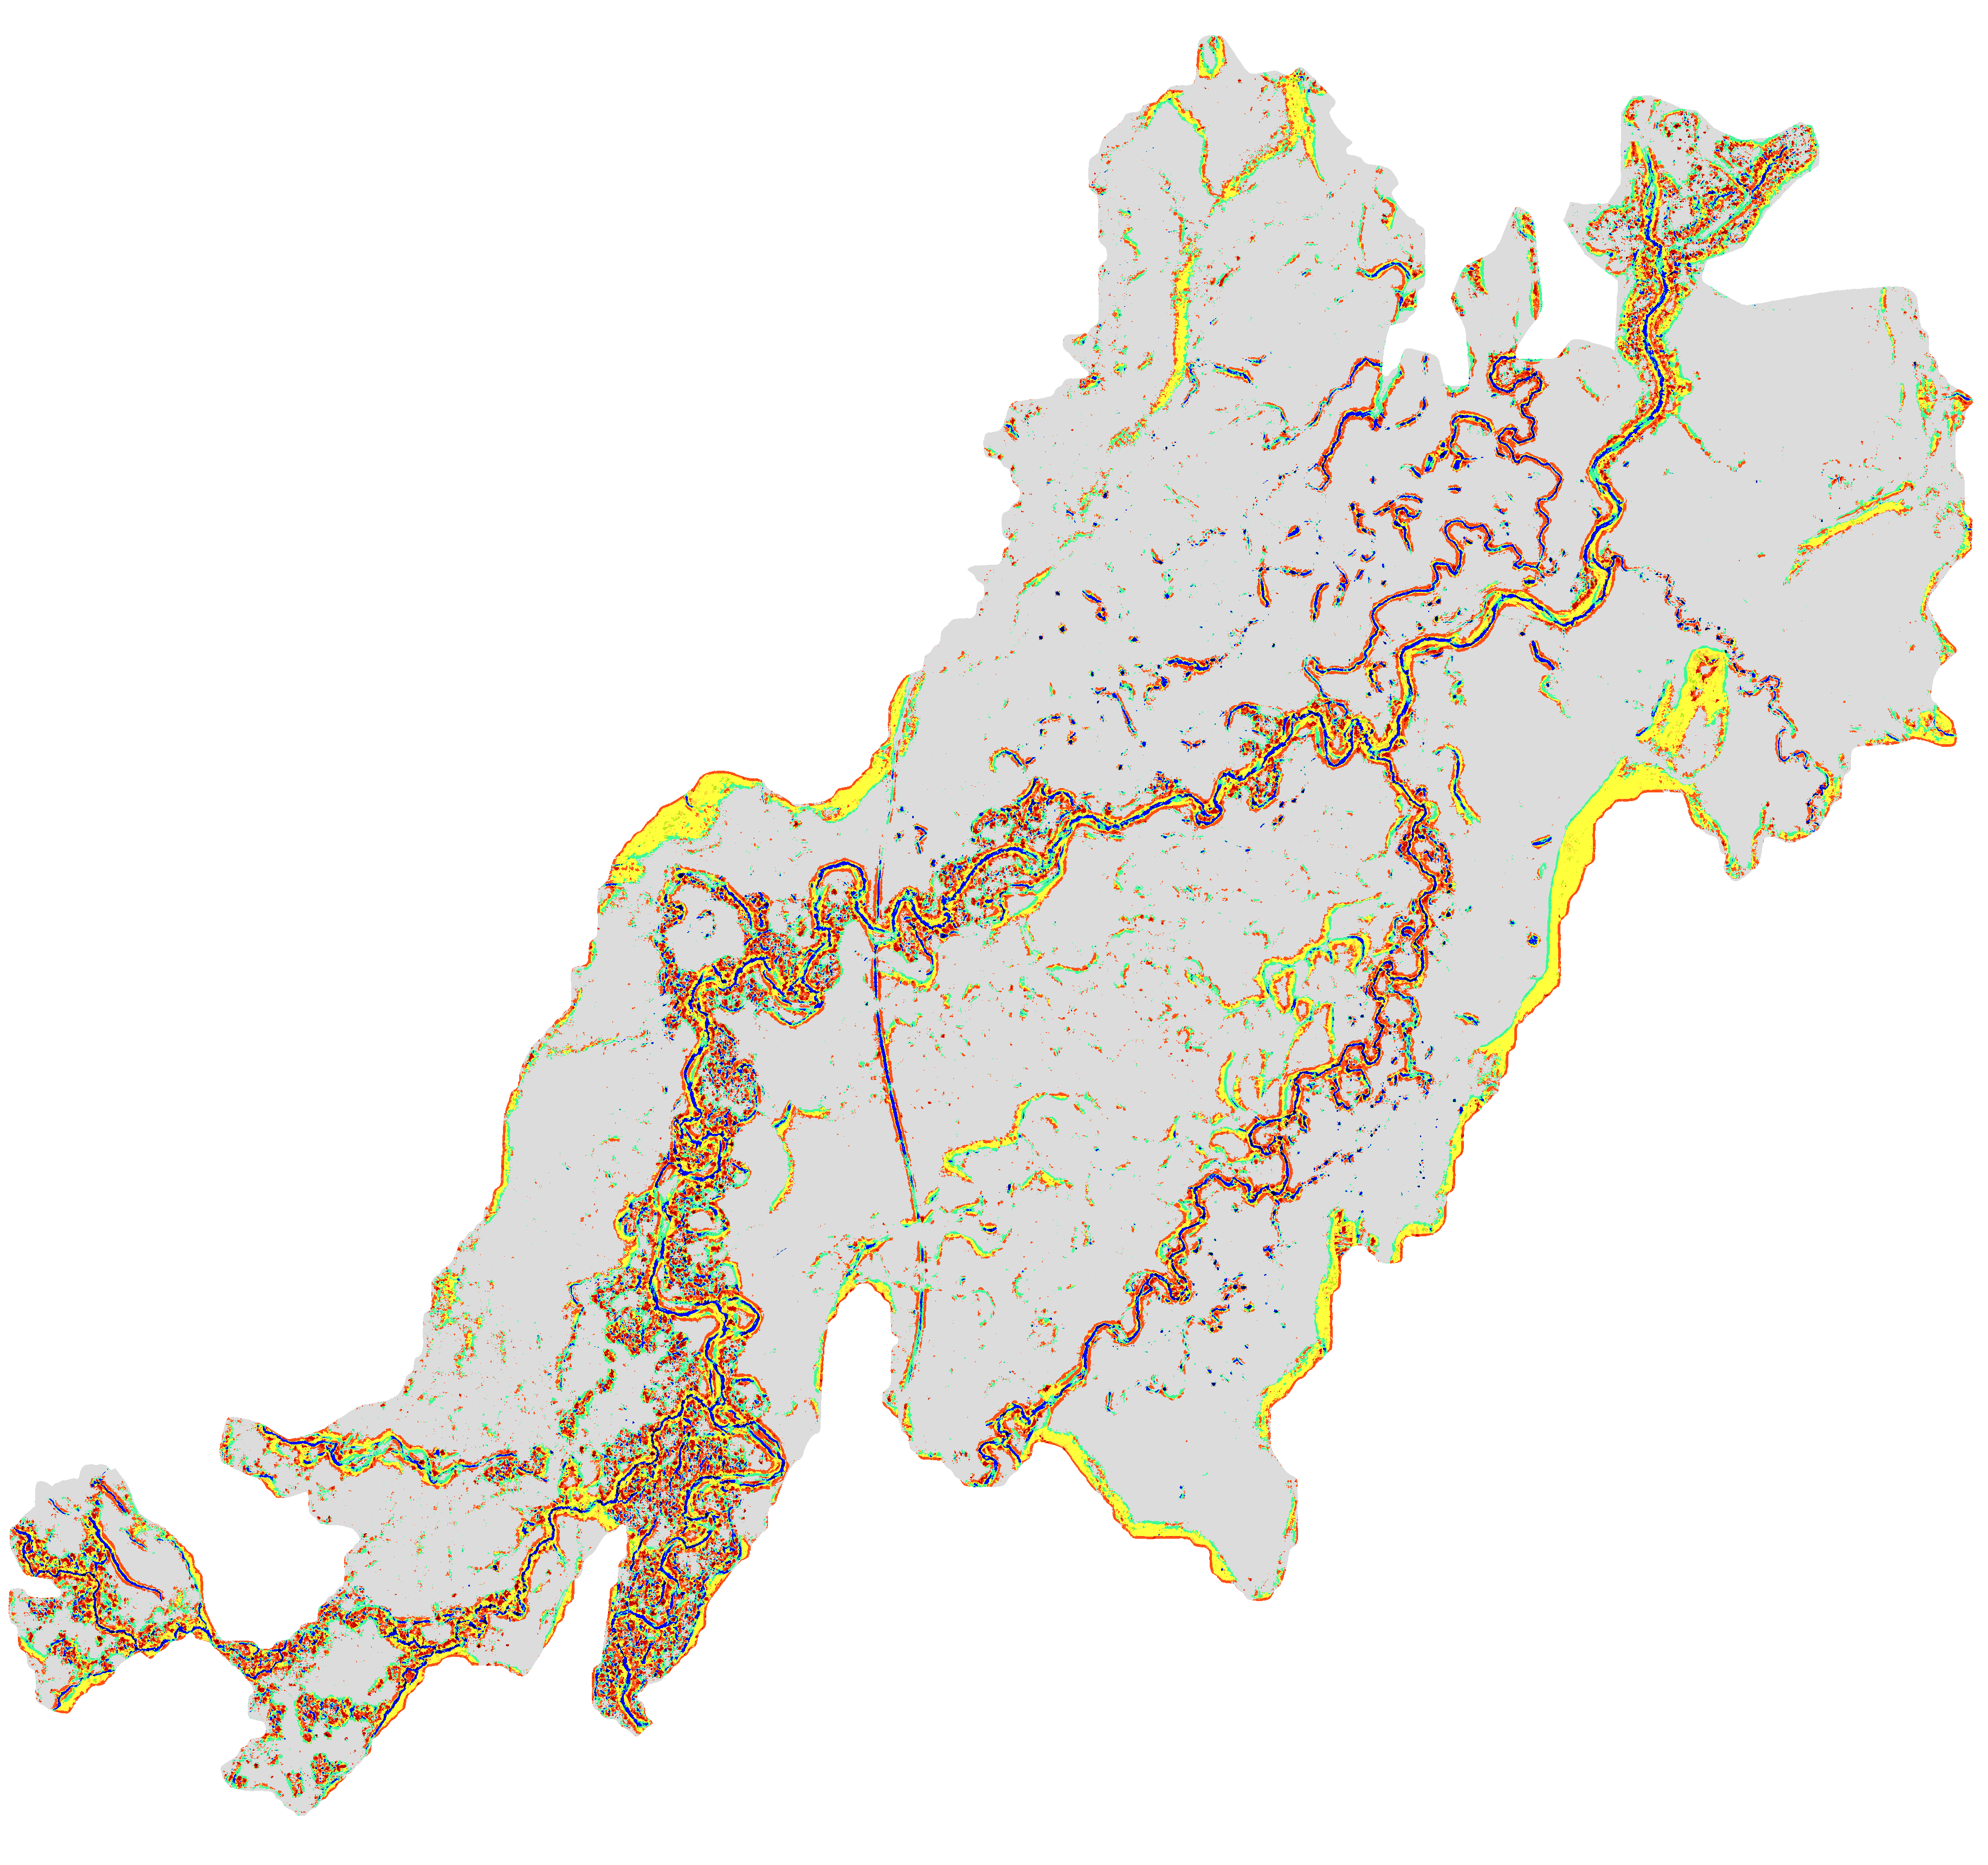

In [39]:
m.add_child(folium.LayerControl())